In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(21664, 28)
(21664, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, 22] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [8]:
X_motion_FR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.71802564e-02,
       -6.32287577e-04,  9.14495711e-03, -1.35179068e-04,  1.55370941e-03,
       -2.33552539e-03,  2.31577652e-01,  1.40405958e-01, -4.08439356e-01,
        2.34574630e-01, -1.38695534e-01, -4.08419712e-01, -2.45801940e-01,
        1.39991647e-01, -4.08426021e-01, -2.48502439e-01, -1.39449617e-01,
       -4.08405932e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_FR_swinging[0, :]

array([-0.00740647, -0.01888334, -0.00686052,  0.016514  ])

### Linear Regression

In [29]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 3:9],
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.994941098874373
RMSE:  0.005933118174299412
The lowest error is:  8.473543542455997e-07
The highest error is:  0.1175324396601132
The avg. error is:  0.0031819786774497385


In [30]:
model_fr_relative_swinging_x.coef_

array([[ 0.05574284,  0.01435029,  0.0313532 ,  0.22243261, -0.02589252,
         0.01058334,  0.00516258, -0.0394547 ,  0.0185532 ,  0.00051325,
         0.11906083,  0.00169464,  0.02944117,  0.06573215, -0.15231285,
        -0.07912396, -0.12269827, -0.08068744,  0.0202072 ,  0.04245839]])

In [26]:
model_fr_relative_swinging_x.intercept_

array([-0.00703511])

Text(0, 0.5, 'Predictions')

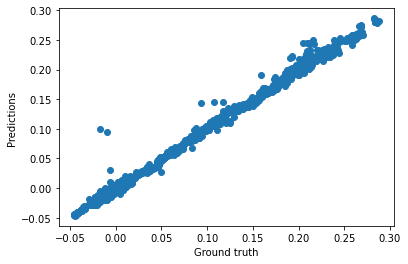

In [27]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [28]:
#%store model_fr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [31]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 3:9],
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9939186106971686
RMSE:  0.006118889614006583
The lowest error is:  4.354034929076808e-06
The highest error is:  0.15397973238548274
The avg. error is:  0.003307090938850156


In [32]:
model_fr_relative_swinging_y.coef_

array([[ 0.01651946,  0.0461886 , -0.0250572 , -0.01670357,  0.23982355,
        -0.02373036,  0.02814047,  0.05140617,  0.10980504,  0.01656614,
         0.04823836, -0.03509313, -0.09667832, -0.08705281, -0.11000973,
        -0.02117264, -0.09498864, -0.02625809, -0.10019543, -0.0908613 ]])

In [33]:
model_fr_relative_swinging_y.intercept_

array([-0.00115294])

Text(0, 0.5, 'Predictions')

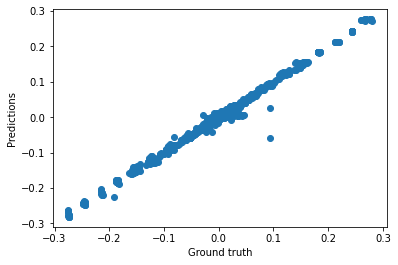

In [34]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_fr_relative_swinging_y

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [23]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")